In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import random

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio --unzip

 95% 409M/429M [00:02<00:00, 199MB/s]
100% 429M/429M [00:02<00:00, 165MB/s]


In [ ]:
!kaggle datasets download ejlok1/toronto-emotional-speech-set-tess --unzip

 96% 409M/428M [00:02<00:00, 173MB/s]
100% 428M/428M [00:02<00:00, 166MB/s]


In [ ]:
!kaggle datasets download ejlok1/cremad --unzip

 96% 433M/451M [00:02<00:00, 156MB/s]
100% 451M/451M [00:02<00:00, 177MB/s]


In [ ]:
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess --unzip

100% 427M/428M [00:02<00:00, 218MB/s]
100% 428M/428M [00:02<00:00, 199MB/s]


In [ ]:
!kaggle datasets download ejlok1/surrey-audiovisual-expressed-emotion-savee --unzip

 84% 90.0M/107M [00:00<00:00, 180MB/s]
100% 107M/107M [00:00<00:00, 136MB/s] 


In [ ]:
RAVDESS = "audio_speech_actors_01-24/"
CREMA = "AudioWAV/"
TESS = "TESS Toronto emotional speech set data/"
SAVEE = "ALL/"

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df = Ravdess_df.query("labels != 'female_surprise' & labels != 'male_surprise'")
Ravdess_df.labels.value_counts()

male_neutral      144
female_neutral    144
male_angry         96
male_sad           96
male_disgust       96
male_happy         96
male_fear          96
female_angry       96
female_fear        96
female_happy       96
female_sad         96
female_disgust     96
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        if int(part[2]) == 1:
          emoname="neutral"
        elif int(part[2]) == 3:
          emoname="happy"
        elif int(part[2]) == 4:
          emoname="sad"
        elif int(part[2]) == 5:
          emoname="angry"
        elif int(part[2]) == 6:
          emoname="fear"
        elif int(part[2]) == 7:
          emoname="disgust"

        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df = Ravdess_df.query("labels != 'female_surprise' & labels != 'male_surprise'")
Ravdess_df.labels.value_counts()

In [ ]:
import os
import shutil

# Definiowanie ścieżek i emocji
test_data_folder = 'content/'
emotions = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']

# Sprawdzenie, czy folder test_data istnieje, jeśli nie, to go tworzymy
if not os.path.exists(test_data_folder):
    os.makedirs(test_data_folder)

# Iterowanie przez foldery aktorów
actor_folders = [f for f in os.listdir(RAVDESS) if not f.startswith('.')]
for actor_id, actor_folder in enumerate(actor_folders):
    actor_path = os.path.join(RAVDESS, actor_folder)
    # Zbieranie nagrań dla każdej emocji
    for emotion in emotions:
        # Wyszukiwanie pierwszego nagrania danej emocji
        for file in os.listdir(actor_path):
            if file.endswith('.wav') and emotion in file:
                source_file = os.path.join(actor_path, file)
                destination_file = os.path.join(test_data_folder, f'{actor_id}{emotion}.wav')
                shutil.copy(source_file, destination_file)
                break  # Przechodzimy do następnej emocji po znalezieniu pierwszego nagrania

print("Nagrania zostały skopiowane.")


Nagrania zostały skopiowane.


In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(TESS)

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            None
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_disgust    400
female_neutral    400
female_sad        400
female_fear       400
female_angry      400
female_happy      400
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(SAVEE)

emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        None
    else:
        None
    path.append(SAVEE + i)

SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral    120
male_disgust     60
male_fear        60
male_sad         60
male_angry       60
male_happy       60
Name: labels, dtype: int64

In [ ]:
# merge all data frames together
data_path = pd.concat([Ravdess_df, CREMA_df, TESS_df, SAVEE_df], axis = 0)

# save the data frame and make index=False because we will have 4 records for each index
data_path.to_csv("new_data_path.csv",index=False)
print(len(data_path))
data_path.head()

11970


,labels,source,path
0,male_angry,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-05-01...
1,male_sad,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-04-02...
2,male_sad,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-04-02...
3,male_disgust,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-07-02...
4,male_happy,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-03-02...


In [ ]:
# read data frame and make sure that each index has one record not 4
data_path = pd.read_csv('new_data_path.csv')
data_path

,labels,source,path
0,male_angry,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-05-01...
1,male_sad,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-04-02...
2,male_sad,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-04-02...
3,male_disgust,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-07-02...
4,male_happy,RAVDESS,audio_speech_actors_01-24/Actor_01/03-01-03-02...
...,...,...,...
11965,NaN,NaN,ALL/KL_a12.wav
11966,NaN,NaN,ALL/KL_n18.wav
11967,NaN,NaN,ALL/JE_su04.wav
11968,NaN,NaN,ALL/DC_su06.wav


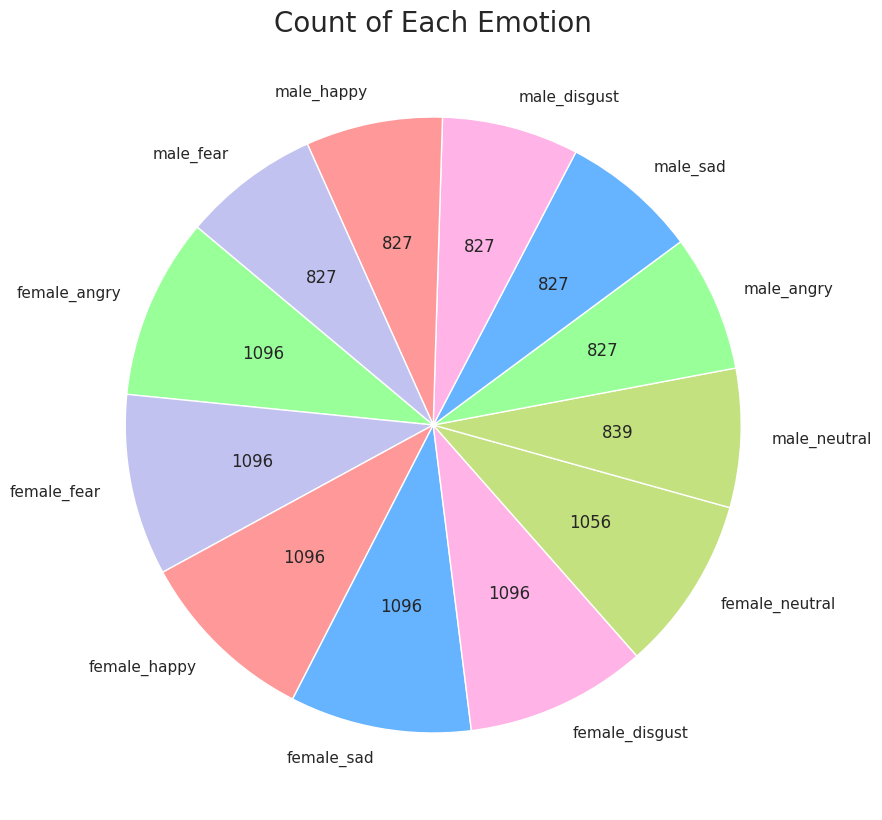

In [ ]:
import matplotlib.pyplot as plt

# Liczenie wystąpień dla każdej etykiety
labels_counts = data_path.labels.value_counts()

# Zdefiniowane kolory dla emocji
pie_colors = {
    'male_happy': '#ff9999',
    'male_sad': '#66b3ff',
    'male_angry': '#99ff99',
    'male_fear': '#c2c2f0',
    'male_disgust': '#ffb3e6',
    'male_neutral': '#c4e17f',
    'female_happy': '#ff9999',
    'female_sad': '#66b3ff',
    'female_angry': '#99ff99',
    'female_fear': '#c2c2f0',
    'female_disgust': '#ffb3e6',
    'female_neutral': '#c4e17f',
}



labels_to_keep = list(pie_colors.keys())

# Filter the DataFrame to keep only rows with these labels
filtered_data = data_path[data_path['labels'].isin(labels_to_keep)]

# Count occurrences of each label in the filtered DataFrame
labels_counts = filtered_data['labels'].value_counts()



# Tworzenie listy kolorów odpowiadającej etykietom
colors_list = [pie_colors[label] for label in labels_counts.index]
plt.figure(figsize=(10, 10))  # Zmieniono rozmiar, aby lepiej pasował do wykresu kołowego
plt.pie(labels_counts, labels=labels_counts.index, colors=colors_list,
        autopct=lambda p: '{:.0f}'.format(p * sum(labels_counts) / 100), startangle=140)
plt.title('Count of Each Emotion', size=20)
plt.show()

In [ ]:
filtered_data.shape

(11510, 5)

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data,rate=speed_factor)

In [ ]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()

In [ ]:
#sample_rate = 22050

def extract_features(data):

    result = np.array([])

    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [ ]:
X, Y = [], []

for path, emotion in zip(filtered_data.path, filtered_data.labels):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), filtered_data.path.shape

(80570, 80570, (11510,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('New_Features.csv', index=False)
print(len(Features))
Features.head()

80570


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-467.406067,52.420807,-7.031424,10.830771,-4.428555,-4.906848,-9.143121,-11.159567,-17.296751,-8.546916,...,1.641893,-0.241143,0.628778,0.439172,1.989468,0.033593,0.065166,-0.797621,-0.291481,male_angry
1,-295.890667,22.593926,4.026267,6.398412,-1.426561,-2.670631,-4.212204,-6.267047,-7.678634,-6.304290,...,0.827164,0.592203,0.473893,0.814031,1.181496,0.406983,-0.564247,-0.135177,-0.123265,male_angry
2,-490.097137,50.835522,-8.015442,10.909920,-5.123621,-5.471134,-9.449430,-11.801551,-17.480059,-9.378897,...,1.789550,-0.161271,0.677207,0.443710,2.101225,0.278917,0.441826,-0.700022,-0.533069,male_angry
3,-468.000031,52.415752,-6.988199,10.811182,-4.424123,-4.905305,-9.128611,-11.099570,-17.225338,-8.472941,...,1.626257,-0.272113,0.618603,0.434681,1.989619,0.053360,0.058481,-0.796389,-0.271596,male_angry
4,-479.605438,50.082130,-9.309715,10.419017,-7.802065,-5.785208,-11.540515,-13.176130,-18.485910,-7.769608,...,2.195224,-0.251108,2.181792,0.296235,0.496787,-2.138548,0.547382,-1.017356,0.116900,male_angry


In [ ]:
Features = pd.read_csv('New_Features.csv')
Features

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-467.406067,52.420807,-7.031424,10.830771,-4.428555,-4.906848,-9.143121,-11.159567,-17.296751,-8.546916,...,1.641893,-0.241143,0.628778,0.439172,1.989468,0.033593,0.065166,-0.797621,-0.291481,male_angry
1,-295.890667,22.593926,4.026267,6.398412,-1.426561,-2.670631,-4.212204,-6.267047,-7.678634,-6.304290,...,0.827164,0.592203,0.473893,0.814031,1.181496,0.406983,-0.564247,-0.135177,-0.123265,male_angry
2,-490.097137,50.835522,-8.015442,10.909920,-5.123621,-5.471134,-9.449430,-11.801551,-17.480059,-9.378897,...,1.789550,-0.161271,0.677207,0.443710,2.101225,0.278917,0.441826,-0.700022,-0.533069,male_angry
3,-468.000031,52.415752,-6.988199,10.811182,-4.424123,-4.905305,-9.128611,-11.099570,-17.225338,-8.472941,...,1.626257,-0.272113,0.618603,0.434681,1.989619,0.053360,0.058481,-0.796389,-0.271596,male_angry
4,-479.605438,50.082130,-9.309715,10.419017,-7.802065,-5.785208,-11.540515,-13.176130,-18.485910,-7.769608,...,2.195224,-0.251108,2.181792,0.296235,0.496787,-2.138548,0.547382,-1.017356,0.116900,male_angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80565,-400.614075,124.953827,23.558960,45.512653,-0.239046,-20.157408,7.102536,5.747311,-6.897745,3.713959,...,3.612998,2.879880,4.573221,6.219131,6.793532,7.634436,8.102967,8.394697,6.176733,male_sad
80566,-376.255310,131.506973,26.713600,47.385914,-0.259897,-19.996798,7.342811,5.221056,-7.237757,3.286521,...,3.445423,2.351609,3.887317,5.379281,6.361497,7.856939,8.148814,7.972076,6.108376,male_sad
80567,-414.844116,142.119720,20.805267,49.351284,-5.512176,-20.214096,9.758430,3.158326,-8.969090,3.463807,...,3.500900,5.753893,8.417678,8.758063,9.539166,8.754256,7.743637,5.818797,5.505866,male_sad
80568,-399.016022,135.769257,20.705265,47.737358,-1.534056,-21.033283,6.476994,6.310816,-7.790191,3.757349,...,4.469169,2.445151,3.817137,5.778068,7.049497,7.689694,7.823825,8.291316,6.322644,male_sad


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y_res = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_res,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64456, 58), (64456, 12), (16114, 58), (16114, 12))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64456, 58, 1), (64456, 12), (16114, 58, 1), (16114, 12))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional

from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(58, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(12, activation="softmax"))


model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 58, 512)           3072      
                                                                 
 batch_normalization_6 (Batc  (None, 58, 512)          2048      
 hNormalization)                                                 
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 29, 512)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 29, 512)           1311232   
                                                                 
 batch_normalization_7 (Batc  (None, 29, 512)          2048      
 hNormalization)                                                 
                                                      

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp,earlystopping])

Epoch 1/50
1008/1008 [==============================] - 74s 71ms/step - loss: 1.5012 - accuracy: 0.4574 - val_loss: 1.6532 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 2/50
1008/1008 [==============================] - 71s 70ms/step - loss: 1.2107 - accuracy: 0.5455 - val_loss: 1.4807 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 3/50
1008/1008 [==============================] - 71s 70ms/step - loss: 1.0875 - accuracy: 0.5870 - val_loss: 1.3443 - val_accuracy: 0.5126 - lr: 0.0010
Epoch 4/50
1008/1008 [==============================] - 71s 70ms/step - loss: 0.9843 - accuracy: 0.6287 - val_loss: 1.2761 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 5/50
1008/1008 [==============================] - 71s 70ms/step - loss: 0.8826 - accuracy: 0.6704 - val_loss: 1.1198 - val_accuracy: 0.6079 - lr: 0.0010
Epoch 6/50
1008/1008 [==============================] - 70s 70ms/step - loss: 0.7897 - accuracy: 0.7067 - val_loss: 0.8752 - val_accuracy: 0.6632 - lr: 0.0010
Epoch 7/50
1008/1008 [========================

504/504 [==============================] - 5s 9ms/step - loss: 0.4475 - accuracy: 0.9247
Accuracy of our model on test data :  92.47 %


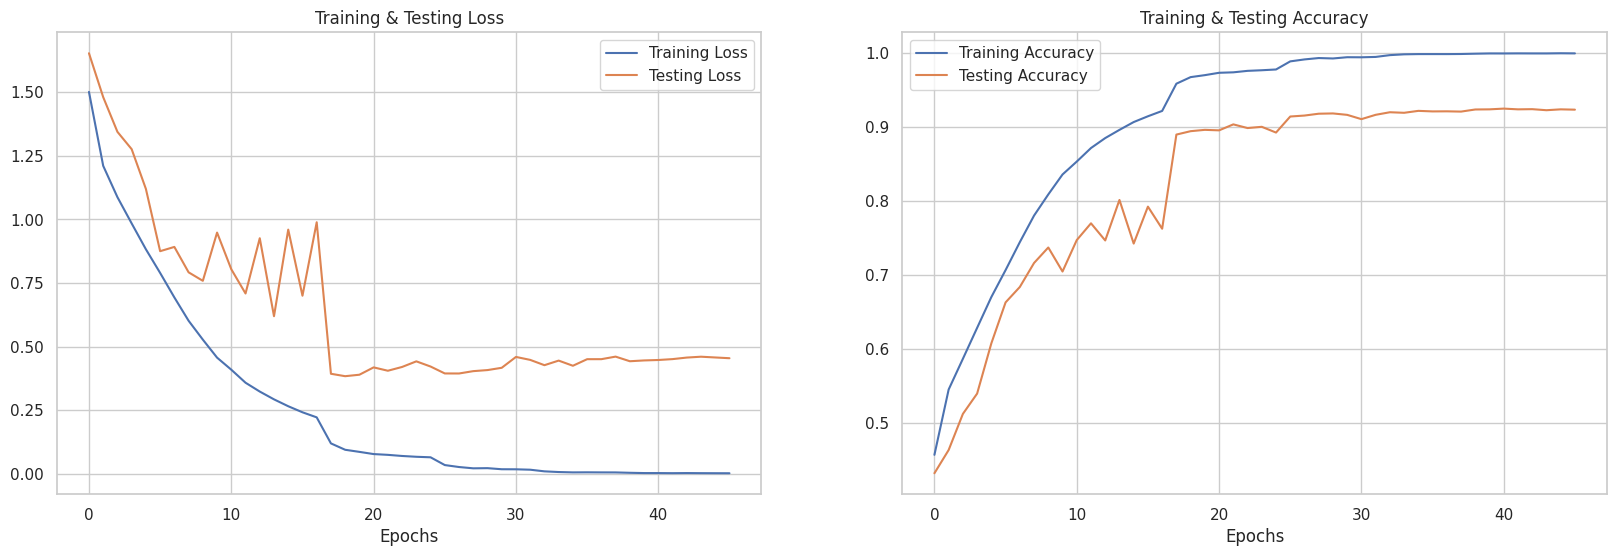

In [ ]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(46)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

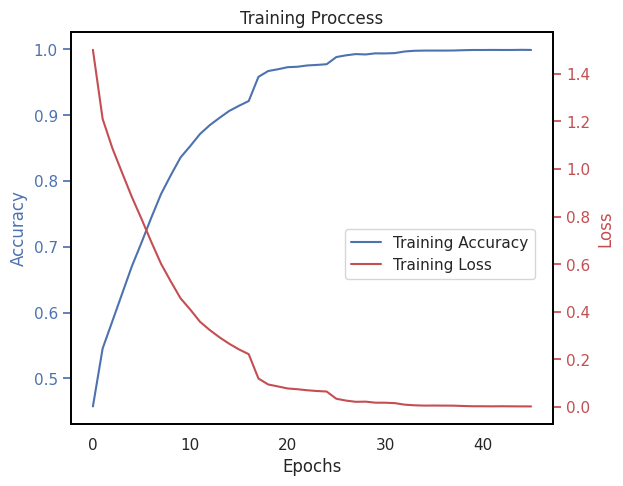

In [ ]:
fig, ax1 = plt.subplots()

# Wykresy dla dokładności
ax2 = ax1.twinx()
ax1.plot(epochs, train_acc, label='Training Accuracy', color='b')

ax2.plot(epochs, train_loss, label='Training Loss', color='r')
# ax1.plot(epochs, test_acc, label='Testing Accuracy', color='g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')

ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')

for spine in ax1.spines.values():
    spine.set_edgecolor('black')

for spine in ax2.spines.values():
    spine.set_edgecolor('black')

ax1.set_facecolor('white')  # Ustawienie białego tła
ax1.grid(False)  # Usunięcie siatki
ax2.set_facecolor('white')  # Ustawienie białego tła
ax2.grid(False)  # Usunięcie siatki
fig.tight_layout()
plt.title('Training Proccess')
fig.legend(loc='center right', bbox_to_anchor=(0.86, 0.5), facecolor='white')
plt.show()

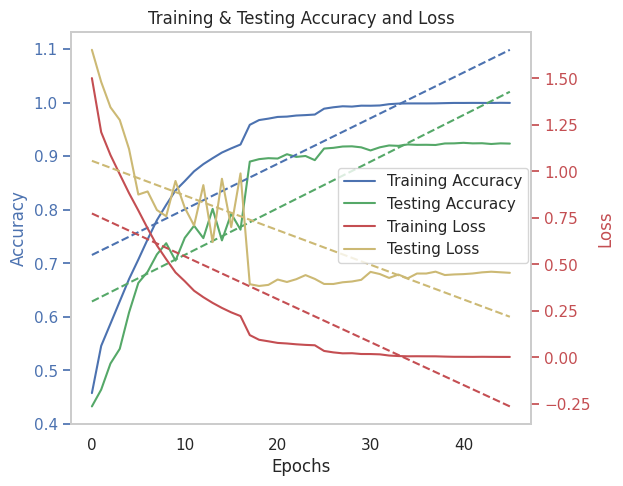

In [ ]:
fig, ax1 = plt.subplots()

# Wykresy dla dokładności
ax1.plot(epochs, train_acc, label='Training Accuracy', color='b')
ax1.plot(epochs, test_acc, label='Testing Accuracy', color='g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')

# Trend lines for accuracy
z_train_acc = np.polyfit(epochs, train_acc, 1)
p_train_acc = np.poly1d(z_train_acc)
ax1.plot(epochs, p_train_acc(epochs), linestyle="--", color='b')

z_test_acc = np.polyfit(epochs, test_acc, 1)
p_test_acc = np.poly1d(z_test_acc)
ax1.plot(epochs, p_test_acc(epochs), linestyle="--", color='g')

# Druga oś Y dla straty
ax2 = ax1.twinx()
ax2.plot(epochs, train_loss, label='Training Loss', color='r')
ax2.plot(epochs, test_loss, label='Testing Loss', color='y')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')

# Trend lines for loss
z_train_loss = np.polyfit(epochs, train_loss, 1)
p_train_loss = np.poly1d(z_train_loss)
ax2.plot(epochs, p_train_loss(epochs), linestyle="--", color='r')

z_test_loss = np.polyfit(epochs, test_loss, 1)
p_test_loss = np.poly1d(z_test_loss)
ax2.plot(epochs, p_test_loss(epochs), linestyle="--", color='y')

ax1.set_facecolor('white')  # Ustawienie białego tła
ax1.grid(False)  # Usunięcie siatki
ax2.set_facecolor('white')  # Ustawienie białego tła
ax2.grid(False)  # Usunięcie siatki
fig.tight_layout()
plt.title('Training & Testing Accuracy and Loss')
fig.legend(loc='center right', bbox_to_anchor=(0.85, 0.58))
plt.show()

In [ ]:
# Save model and weights
model_name = 'MFCC_MODEL.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("MFCC_MODEL.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/MFCC_MODEL.h5 


In [ ]:
# loading json and model architecture
json_file = open('/content/MFCC_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/saved_models/MFCC_MODEL.h5")
print("Loaded model from disk")

# Keras optimiser
loaded_model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Loaded model from disk


In [ ]:
import pickle

# Saving encoder
with open('/encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [ ]:
preds = loaded_model.predict(x_test)

504/504 [==============================] - 5s 9ms/step


In [ ]:
# predicting on test data.
y_pred = encoder.inverse_transform(preds)
y_tmp = encoder.inverse_transform(y_test)

In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_neutral,female_neutral
1,male_sad,male_disgust
2,female_fear,female_fear
3,female_neutral,female_neutral
4,male_happy,male_happy
...,...,...
16109,female_angry,female_angry
16110,male_neutral,male_sad
16111,female_fear,female_fear
16112,female_neutral,female_neutral


Accuracy of our model on test data based on emotions:  93.0 %


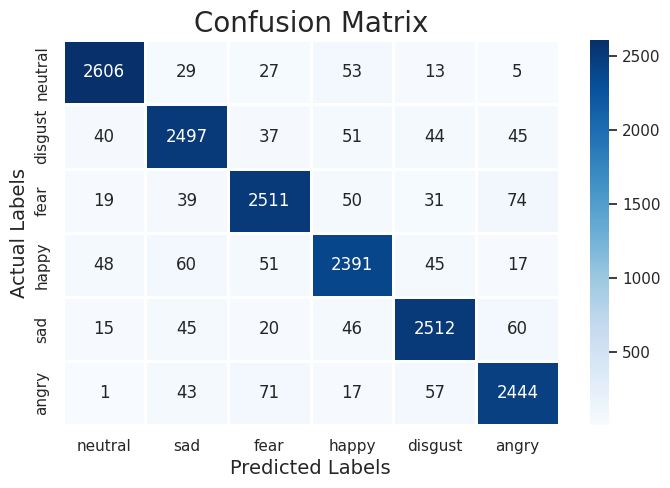

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on emotions: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.0f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96      2687
     disgust       0.91      0.92      0.92      2663
        fear       0.93      0.92      0.92      2691
       happy       0.93      0.92      0.92      2697
     neutral       0.93      0.93      0.93      2659
         sad       0.92      0.93      0.93      2704
    surprise       0.97      0.98      0.98       926

    accuracy                           0.93     17027
   macro avg       0.94      0.94      0.94     17027
weighted avg       0.93      0.93      0.93     17027



In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_sad,female_sad
1,female_disgust,female_disgust
2,male_fear,male_fear
3,female_sad,female_sad
4,female_angry,female_angry
...,...,...
17022,male_angry,male_angry
17023,male_disgust,male_happy
17024,female_disgust,female_disgust
17025,male_sad,male_sad


Accuracy of our model on test data based on gender:  99.0 %


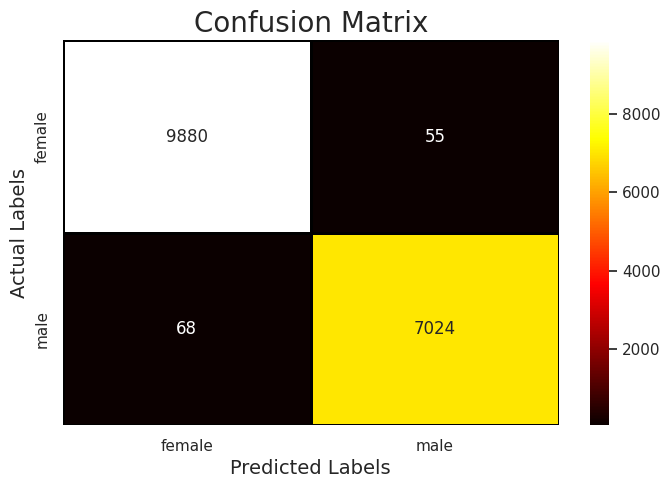

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on gender: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

      female       0.99      0.99      0.99      9935
        male       0.99      0.99      0.99      7092

    accuracy                           0.99     17027
   macro avg       0.99      0.99      0.99     17027
weighted avg       0.99      0.99      0.99     17027

